Training tanh network on CIFAR10 using cuda:0
Using GPU-accelerated surrogate gamma calculation method
Using GPU DataLoader
Files already downloaded and verified
Preprocessing and loading data to cuda:0...
Successfully loaded 50000 samples to cuda:0
Epoch 1 completed, Avg Loss: 1.9104
Epoch 2 completed, Avg Loss: 1.7661
Epoch 3 completed, Avg Loss: 1.7222
Epoch 4 completed, Avg Loss: 1.6860
Epoch 5 completed, Avg Loss: 1.6521
Epoch 6 completed, Avg Loss: 1.6247
Epoch 7 completed, Avg Loss: 1.5911
Epoch 8 completed, Avg Loss: 1.5674
Epoch 9 completed, Avg Loss: 1.5415
Epoch 10 completed, Avg Loss: 1.5094
Epoch 11 completed, Avg Loss: 1.4840
Epoch 12 completed, Avg Loss: 1.4558
Epoch 13 completed, Avg Loss: 1.4282
Epoch 14 completed, Avg Loss: 1.4029
Epoch 15 completed, Avg Loss: 1.3765
Epoch 16 completed, Avg Loss: 1.3571
Epoch 17 completed, Avg Loss: 1.3197
Epoch 18 completed, Avg Loss: 1.2956
Epoch 19 completed, Avg Loss: 1.2723
Epoch 20 completed, Avg Loss: 1.2445
Epoch 21 completed,

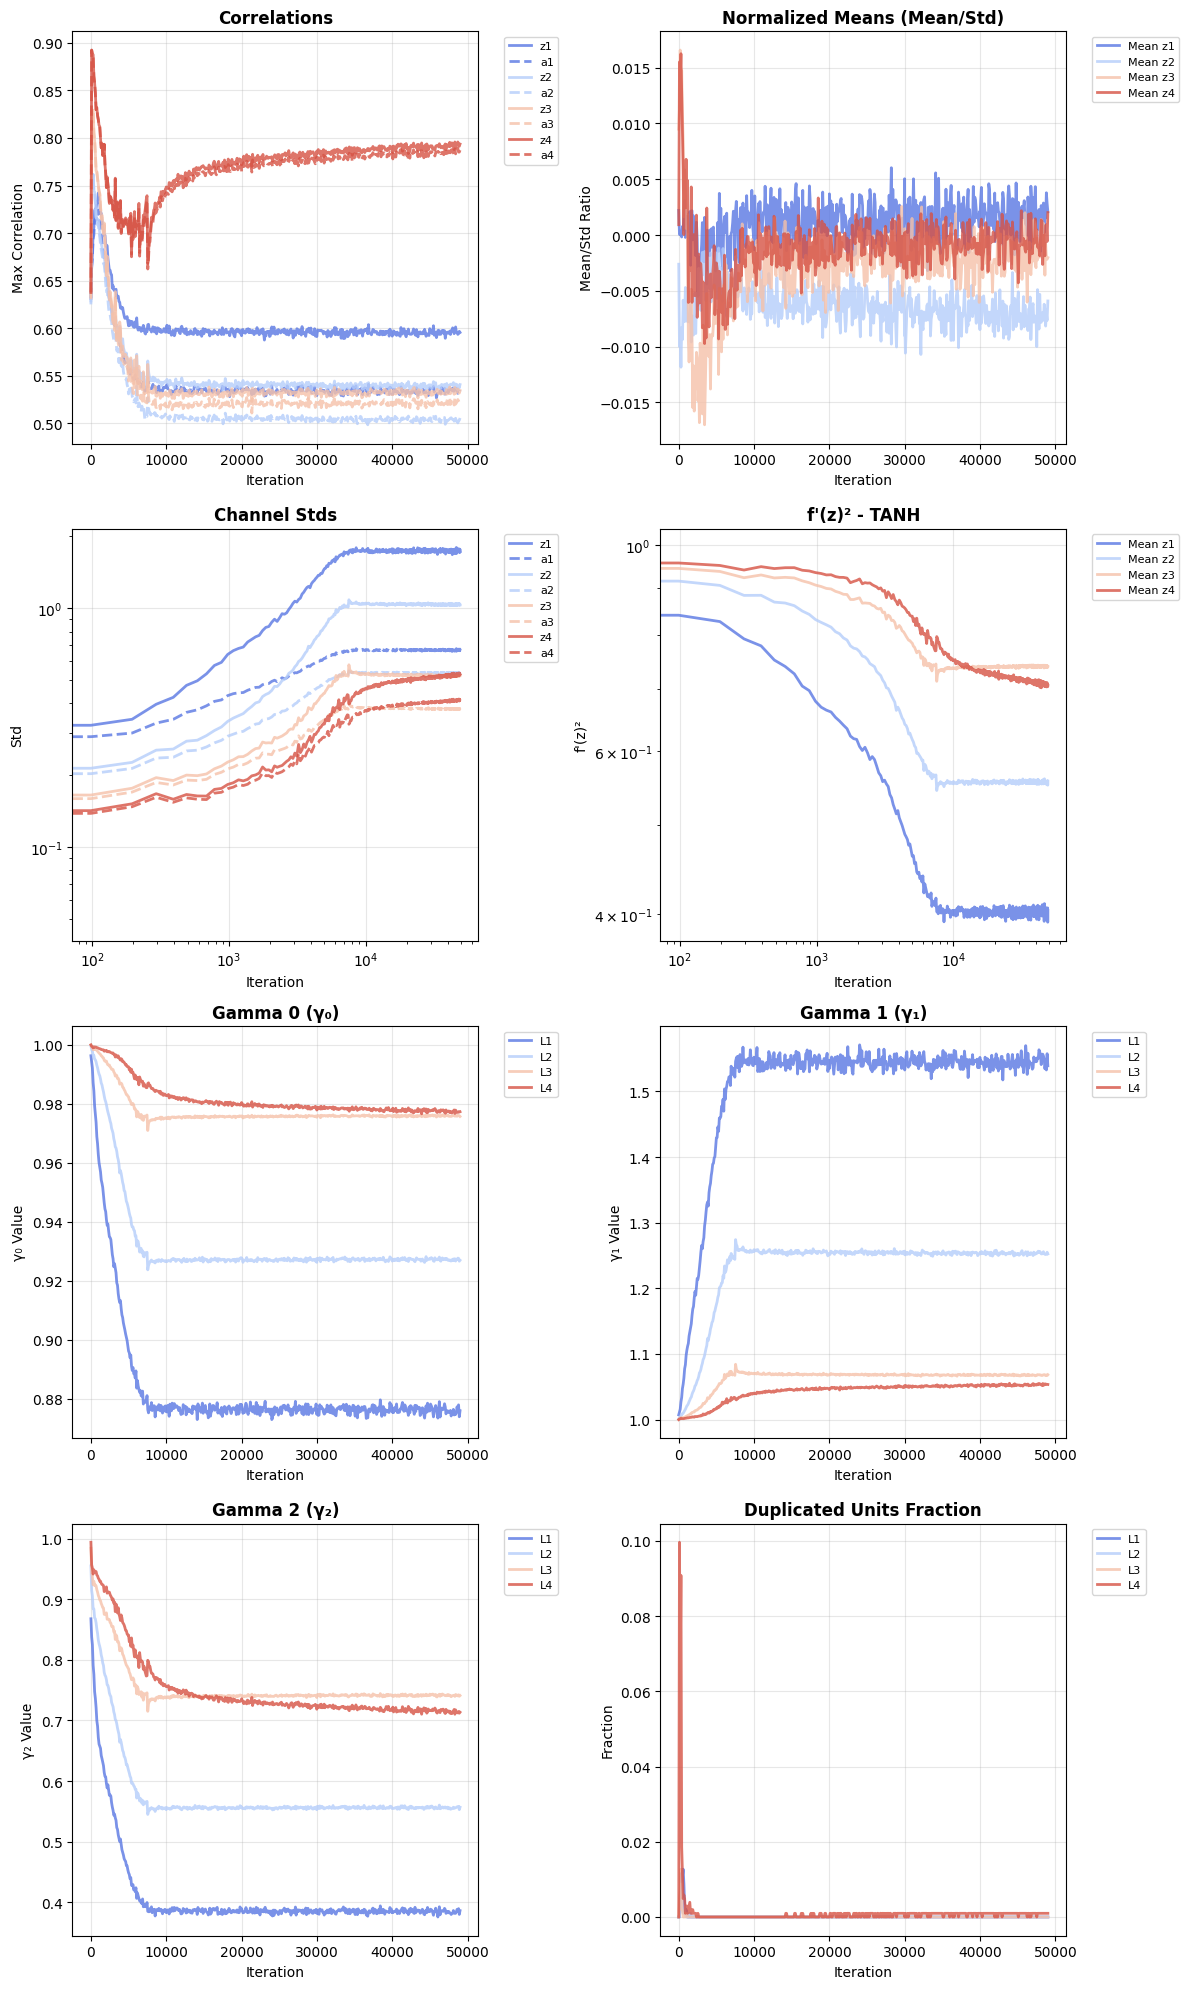


Training completed in 149.45 seconds
Samples used: 50000

Final metrics for 4-layer tanh network on CIFAR10:
Layer 1: Corr(z/a)=0.596/0.535, Norm(z)=0.002±0.201, f'(z)²=0.404±0.188, γ=(γ0:0.876, γ1:1.539, γ2:0.386), Dup=0.000
Layer 2: Corr(z/a)=0.541/0.506, Norm(z)=-0.006±0.218, f'(z)²=0.557±0.231, γ=(γ0:0.927, γ1:1.252, γ2:0.557), Dup=0.000
Layer 3: Corr(z/a)=0.535/0.523, Norm(z)=-0.002±0.227, f'(z)²=0.740±0.169, γ=(γ0:0.976, γ1:1.068, γ2:0.741), Dup=0.000
Layer 4: Corr(z/a)=0.794/0.787, Norm(z)=0.002±0.153, f'(z)²=0.706±0.140, γ=(γ0:0.977, γ1:1.054, γ2:0.714), Dup=0.001


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader

# Import for caching and type hinting
import math
from functools import lru_cache
from typing import Callable, Tuple, Dict, Any

# NumPy imports for specific quadrature node generation
from numpy.polynomial.hermite import hermgauss

# ----------------------------
# GPU DataLoader Implementation
# ----------------------------

class GPUDataLoader:
    """Drop-in replacement for DataLoader that preloads data to GPU"""
    
    def __init__(self, dataset, batch_size=1, shuffle=False, device='cpu', max_samples=None):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device
        self.max_samples = max_samples
        
        # Preprocess and load data to GPU
        self.data, self.targets = self._preload_data(dataset)
        self.n_samples = len(self.data)
        
    def _preload_data(self, dataset):
        """Preprocess entire dataset and load to GPU"""
        print(f"Preprocessing and loading data to {self.device}...")
        
        # Determine how many samples to use
        n_total = len(dataset)
        n_use = min(self.max_samples or n_total, n_total)
        
        if n_use < n_total:
            print(f"Using {n_use}/{n_total} samples")
            indices = torch.randperm(n_total)[:n_use]
            subset = torch.utils.data.Subset(dataset, indices)
            temp_loader = DataLoader(subset, batch_size=n_use, shuffle=False)
        else:
            temp_loader = DataLoader(dataset, batch_size=n_total, shuffle=False)
        
        try:
            # Load and preprocess all data at once
            data, targets = next(iter(temp_loader))
            
            # Move to device
            data = data.to(self.device)
            targets = targets.to(self.device)
            
            print(f"Successfully loaded {len(data)} samples to {self.device}")
            return data, targets
            
        except torch.cuda.OutOfMemoryError:
            print("GPU OOM! Trying with fewer samples...")
            fallback_samples = min(10000, n_use // 2)
            return self._preload_data_with_limit(dataset, fallback_samples)
    
    def _preload_data_with_limit(self, dataset, max_samples):
        """Fallback method with limited samples"""
        indices = torch.randperm(len(dataset))[:max_samples]
        subset = torch.utils.data.Subset(dataset, indices)
        temp_loader = DataLoader(subset, batch_size=max_samples, shuffle=False)
        data, targets = next(iter(temp_loader))
        return data.to(self.device), targets.to(self.device)
    
    def __iter__(self):
        """Iterator that yields batches like standard DataLoader"""
        if self.shuffle:
            indices = torch.randperm(self.n_samples, device=self.device)
        else:
            indices = torch.arange(self.n_samples, device=self.device)
        
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i + self.batch_size]
            yield self.data[batch_indices], self.targets[batch_indices]
    
    def __len__(self):
        """Number of batches"""
        return (self.n_samples + self.batch_size - 1) // self.batch_size

def get_dataloader(dataset, config, is_train=True):
    """Factory function to create appropriate dataloader"""
    if config.get('use_gpu_loader', False) and is_train:
        # Use GPU loader for training with memory management
        return GPUDataLoader(dataset, 
                             batch_size=config['batch_size'], 
                             shuffle=True,
                             device=config['device'],
                             max_samples=config.get('max_gpu_samples', None))
    else:
        # Use standard DataLoader
        return DataLoader(dataset, 
                          batch_size=config['batch_size'], 
                          shuffle=is_train,
                          num_workers=config.get('num_workers', 2))

# ---------------------------------------------------------------
# PyTorch-based Metric & Gamma Utilities (GPU Accelerated)
# ---------------------------------------------------------------

# Constants for calculations
SQRT2 = math.sqrt(2.0)
INV_SQRT2PI = 1.0 / math.sqrt(2.0 * math.pi)

def torch_phi(x: torch.Tensor) -> torch.Tensor:
    """Gaussian PDF for PyTorch tensors."""
    return torch.exp(-0.5 * x * x) * INV_SQRT2PI

def torch_Phi(x: torch.Tensor) -> torch.Tensor:
    """Gaussian CDF for PyTorch tensors."""
    return 0.5 * (1.0 + torch.erf(x / SQRT2))

# --- PyTorch implementations of activation functions and their derivatives ---
def get_torch_activation_fns(name: str) -> Tuple[Callable, Callable]:
    """
    Returns a tuple of (activation_fn, derivative_fn) for PyTorch tensors.
    This function has been expanded to include all activations from the original model.
    """
    name = name.lower()
    if name == 'relu':
        return torch.relu, lambda x: (x > 0).float()
    elif name == 'tanh':
        return torch.tanh, lambda x: 1.0 - torch.tanh(x).pow(2)
    elif name == 'sigmoid':
        return torch.sigmoid, lambda x: torch.sigmoid(x) * (1.0 - torch.sigmoid(x))
    elif name == 'gelu':
        fn = nn.functional.gelu
        def deriv(x):
            return torch_Phi(x) + x * torch_phi(x)
        return fn, deriv
    elif name in ['swish', 'silu']:
        fn = nn.functional.silu
        def deriv(x):
            sig_x = torch.sigmoid(x)
            return sig_x + x * sig_x * (1.0 - sig_x)
        return fn, deriv
    elif name == 'leaky_relu':
        # Using default negative_slope=0.01 as in nn.LeakyReLU
        fn = nn.functional.leaky_relu
        def deriv(x):
            return torch.where(x > 0, 1.0, 0.01).to(x.device)
        return fn, deriv
    elif name == 'elu':
        # Using default alpha=1.0 as in nn.ELU
        fn = nn.functional.elu
        def deriv(x):
            return torch.where(x > 0, 1.0, 1.0 * torch.exp(x)).to(x.device)
        return fn, deriv
    elif name == 'selu':
        # SELU constants
        SELU_LAMBDA = 1.0507009873554805
        SELU_ALPHA = 1.6732632423543772
        fn = nn.functional.selu
        def deriv(x):
            return torch.where(x > 0, SELU_LAMBDA, SELU_LAMBDA * SELU_ALPHA * torch.exp(x)).to(x.device)
        return fn, deriv
    elif name == 'mish':
        fn = nn.functional.mish
        def deriv(x):
            sp = nn.functional.softplus(x)
            tanh_sp = torch.tanh(sp)
            sech_sq_sp = 1 - tanh_sp.pow(2)
            sig_x = torch.sigmoid(x)
            return tanh_sp + x * sech_sq_sp * sig_x
        return fn, deriv
    else:
        raise ValueError(f"Activation '{name}' not supported for torch gamma calculation.")

@lru_cache(maxsize=None)
def _herm_nodes(n: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
    """Cached Gauss-Hermite nodes and weights, moved to the specified torch device."""
    x, w = hermgauss(n)
    return torch.tensor(x, device=device, dtype=torch.float32), torch.tensor(w, device=device, dtype=torch.float32)

def torch_gh_expectation(fn: Callable[[torch.Tensor], torch.Tensor], m: torch.Tensor, s: torch.Tensor, n_nodes: int = 128) -> torch.Tensor:
    """
    Vectorized E[fn(X)] where X ~ N(m, s^2) via Gauss–Hermite quadrature on GPU.
    m and s are tensors of shape (n_channels,).
    """
    x, w = _herm_nodes(n_nodes, device=m.device)
    z = m.unsqueeze(1) + s.unsqueeze(1) * (SQRT2 * x)
    vals = fn(z)
    return (vals @ w) / math.sqrt(math.pi)

def relu_moments_closed_torch(m: torch.Tensor, s: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Closed-form moments for ReLU, vectorized for PyTorch tensors."""
    t = m / s
    Ph = torch_Phi(t)
    ph = torch_phi(t)
    mu = s * ph + m * Ph
    Ef2 = (s.pow(2) + m.pow(2)) * Ph + m * s * ph
    Efp = Ph
    Efp2 = Ph
    return mu, Ef2, Efp, Efp2

def get_torch_gamma_calculator(activation: str, gh_nodes: int = 160) -> Callable:
    """Returns a vectorized gamma calculator function for a given activation."""
    act_name = activation.lower()

    if act_name == 'relu':
        def calculator(a: torch.Tensor, b: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            m, s = a * b, a
            mu, Ef2, Efp, Efp2 = relu_moments_closed_torch(m, s)
            var_f = torch.clamp(Ef2 - mu.pow(2), min=1e-12)
            scale = (a.pow(2) / var_f)
            g2 = Efp2
            g1 = scale * g2
            g0 = scale * Efp.pow(2)
            return g0, g1, g2
        return calculator
    
    try:
        act_fn, deriv_fn = get_torch_activation_fns(act_name)
    except ValueError as e:
        print(f"Warning: {e}. Gamma calculation will be skipped.")
        return None

    def calculator(a: torch.Tensor, b: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        m, s = a * b, a
        
        mu   = torch_gh_expectation(act_fn, m, s, n_nodes=gh_nodes)
        Ef2  = torch_gh_expectation(lambda u: act_fn(u).pow(2), m, s, n_nodes=gh_nodes)
        Efp  = torch_gh_expectation(deriv_fn, m, s, n_nodes=gh_nodes)
        Efp2 = torch_gh_expectation(lambda u: deriv_fn(u).pow(2), m, s, n_nodes=gh_nodes)
        
        var_f = torch.clamp(Ef2 - mu.pow(2), min=1e-12)
        scale = (a.pow(2) / var_f)
        
        g2 = Efp2
        g1 = scale * g2
        g0 = scale * Efp.pow(2)
        
        return g0, g1, g2
        
    return calculator

# --- PyTorch-based metric computation functions ---
def compute_max_correlation_torch(arr: torch.Tensor) -> float:
    """Compute mean of max correlations per row from upper triangular matrix using PyTorch."""
    if arr.shape[1] <= 1:
        return 0.0
    corr = torch.corrcoef(arr.T)
    corr.fill_diagonal_(0) # Exclude self-correlation
    max_corrs = torch.max(torch.abs(corr), dim=1).values
    return torch.mean(max_corrs).item()

def compute_duplicated_units_fraction_torch(arr: torch.Tensor, threshold: float = 0.95) -> float:
    """Compute fraction of units with high correlation using PyTorch."""
    if arr.shape[1] <= 1:
        return 0.0
    corr = torch.corrcoef(arr.T)
    upper_tri = torch.triu(torch.abs(corr), diagonal=1)
    is_duplicated = torch.any(upper_tri > threshold, dim=1)
    return (is_duplicated.sum() / arr.shape[1]).item()

# ----------------------------
# Model and Training
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[512, 256], num_classes=10, activation='relu'):
        super().__init__()
        self.activations, self.pre_activations = {}, {}
        
        act_map = {
            'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU(), 'swish': nn.SiLU(), 'silu': nn.SiLU(),
            'leaky_relu': nn.LeakyReLU(0.01), 'elu': nn.ELU(), 'selu': nn.SELU(),
            'mish': nn.Mish()
        }
        self.activation_fn = act_map.get(activation, nn.ReLU())
        self.activation_name = activation
        
        sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        self.activations, self.pre_activations = {}, {}
        
        for i, layer in enumerate(self.layers[:-1]):
            pre_act = layer(x)
            self.pre_activations[i] = pre_act.detach()
            x = self.activation_fn(pre_act)
            self.activations[i] = x.detach()
        
        return self.layers[-1](x)

def calculate_metrics(model, trainloader, device, gh_nodes=160):
    """Calculate all metrics on GPU using PyTorch."""
    model.eval()
    
    # Get the appropriate PyTorch-based activation and derivative functions
    try:
        _, deriv_fn = get_torch_activation_fns(model.activation_name)
    except ValueError as e:
        print(f"Warning: {e}. Derivative calculation will be skipped.")
        deriv_fn = None

    # Get the vectorized gamma calculator
    gamma_calc = get_torch_gamma_calculator(model.activation_name, gh_nodes=gh_nodes)
    
    with torch.no_grad():
        images, _ = next(iter(trainloader))
        
        if not isinstance(trainloader, GPUDataLoader):
            images = images.to(device)
        
        _ = model(images)
        
        metrics = {}
        for layer_idx in model.pre_activations:
            pre_act = model.pre_activations[layer_idx]
            post_act = model.activations[layer_idx]
            
            # --- All calculations are now on GPU tensors ---
            
            # Derivative squared
            deriv_sq_mean, deriv_sq_std = 0.0, 0.0
            if deriv_fn:
                deriv_sq = deriv_fn(pre_act).pow(2)
                deriv_sq_mean = torch.mean(deriv_sq).item()
                deriv_sq_std = torch.std(torch.mean(deriv_sq, dim=0)).item()

            # Normalized stats (Mean/Std per channel)
            channel_means = torch.mean(pre_act, dim=0)
            channel_stds = torch.std(pre_act, dim=0)
            
            # Avoid division by zero
            safe_stds = torch.clamp(channel_stds, min=1e-8)
            normalized_pre_act = channel_means / safe_stds
            
            pre_norm_mean = torch.mean(normalized_pre_act).item()
            pre_norm_std = torch.std(normalized_pre_act).item()
            
            # Gamma values
            gamma0_mean, gamma1_mean, gamma2_mean = 0.0, 0.0, 0.0
            if gamma_calc:
                # Vectorized call to gamma calculator
                mask = channel_stds > 1e-8
                if mask.any():
                    g0, g1, g2 = gamma_calc(channel_stds[mask], normalized_pre_act[mask])
                    gamma0_mean = torch.mean(g0).item()
                    gamma1_mean = torch.mean(g1).item()
                    gamma2_mean = torch.mean(g2).item()
            
            metrics[layer_idx] = {
                'pre_corr': compute_max_correlation_torch(pre_act),
                'post_corr': compute_max_correlation_torch(post_act),
                'pre_norm_mean': pre_norm_mean,
                'pre_norm_std': pre_norm_std,
                'pre_std': torch.mean(channel_stds).item(),
                'post_std': torch.mean(torch.std(post_act, dim=0)).item(),
                'deriv_mean': deriv_sq_mean,
                'deriv_std': deriv_sq_std,
                'gamma0_mean': gamma0_mean,
                'gamma1_mean': gamma1_mean,
                'gamma2_mean': gamma2_mean,
                'duplicated_fraction': compute_duplicated_units_fraction_torch(pre_act, threshold=0.95)
            }
    return metrics

def plot_metrics(metrics_log, config):
    """Create 8-panel plot with separate gamma plots and duplicated units"""
    fig, axes = plt.subplots(4, 2, figsize=(12, 20))
    axes = axes.flatten()
    
    # Extract data
    iterations = [m[0] for m in metrics_log]
    num_layers = len(metrics_log[0][1])
    # Progression color scheme: cool (blue) to warm (red) through the network layers
    colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, num_layers))
    
    # Plot configurations: (metric_pairs, title, ylabel, log_scale)
    plots = [
        (('pre_corr', 'post_corr'), 'Correlations', 'Max Correlation', False),
        (('pre_norm_mean', 'pre_norm_std'), 'Normalized Means (Mean/Std)', 'Mean/Std Ratio', False),
        (('pre_std', 'post_std'), 'Channel Stds', 'Std', True),
        (('deriv_mean', 'deriv_std'), f"f'(z)² - {config['activation'].upper()}", "f'(z)²", True),
        (('gamma0_mean',), 'Gamma 0 (γ₀)', 'γ₀ Value', False),
        (('gamma1_mean',), 'Gamma 1 (γ₁)', 'γ₁ Value', False),
        (('gamma2_mean',), 'Gamma 2 (γ₂)', 'γ₂ Value', False),
        (('duplicated_fraction',), 'Duplicated Units Fraction', 'Fraction', False)
    ]
    
    for ax_idx, (metrics_pair, title, ylabel, log_scale) in enumerate(plots):
        ax = axes[ax_idx]
        
        for layer_idx in range(num_layers):
            color = colors[layer_idx]
            
            # Extract metric data for this layer
            metric1_data = [metrics_log[i][1][layer_idx][metrics_pair[0]] for i in range(len(metrics_log))]
            
            # Plot based on panel type
            if ax_idx in [0, 2]:  # Plots with pre/post lines
                metric2_data = [metrics_log[i][1][layer_idx][metrics_pair[1]] for i in range(len(metrics_log))]
                ax.plot(iterations, metric1_data, color=color, linestyle='-', alpha=0.8, linewidth=2, label=f'z{layer_idx+1}')
                ax.plot(iterations, metric2_data, color=color, linestyle='--', alpha=0.8, linewidth=2, label=f'a{layer_idx+1}')
            elif ax_idx in [1, 3]: # Plots with mean/std error bars or just mean
                 ax.plot(iterations, metric1_data, color=color, linestyle='-', alpha=0.8, linewidth=2, label=f'Mean z{layer_idx+1}')
            else: # Single line plots
                ax.plot(iterations, metric1_data, color=color, linestyle='-', alpha=0.8, linewidth=2, label=f'L{layer_idx+1}')

        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Iteration')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

        if log_scale:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(config['save_path'], dpi=config['dpi'], bbox_inches='tight')
    plt.show()

def train_model_unified(model, dataloader, criterion, optimizer, config):
    """Unified training function that works with both standard and GPU loaders"""
    model.train()
    
    start_time = time.time()
    iteration_count = 0
    losses = []
    
    # Initial metrics
    initial_metrics = calculate_metrics(model, dataloader, config['device'], gh_nodes=config.get('gh_nodes', 160))
    metrics_log = [(0, initial_metrics)]
    
    for epoch in range(config['epochs']):
        model.train()
        epoch_losses = []
        
        for inputs, labels in dataloader:
            if not config.get('use_gpu_loader', False):
                inputs, labels = inputs.to(config['device']), labels.to(config['device'])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            losses.append(loss.item())
            iteration_count += 1
            
            # Log metrics periodically
            if iteration_count % config['calc_every_n_iterations'] == 0:
                metrics = calculate_metrics(model, dataloader, config['device'], gh_nodes=config.get('gh_nodes', 160))
                metrics_log.append((iteration_count, metrics))
                print(f"Epoch {epoch+1}/{config['epochs']}, Iter {iteration_count}, Loss: {loss.item():.4f}")
        
        # End of epoch metrics and logging
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0.0
        final_metrics = calculate_metrics(model, dataloader, config['device'], gh_nodes=config.get('gh_nodes', 160))
        metrics_log.append((iteration_count, final_metrics))
        print(f"Epoch {epoch+1} completed, Avg Loss: {avg_epoch_loss:.4f}")
    
    train_time = time.time() - start_time
    return train_time, metrics_log

def train_and_analyze(config):
    # Setup
    device = torch.device(config['device'] if torch.cuda.is_available() else 'cpu')
    use_gpu_loader = config.get('use_gpu_loader', False)
    
    loader_type = "GPU DataLoader" if use_gpu_loader else "Standard DataLoader"
    print(f"Training {config['activation']} network on {config['dataset'].upper()} using {device}")
    print(f"Using GPU-accelerated surrogate gamma calculation method")
    print(f"Using {loader_type}")
    
    # Dataset-specific configuration
    if config['dataset'] == 'mnist':
        input_size, dataset_class = 784, torchvision.datasets.MNIST
        normalize_mean, normalize_std = (0.1307,), (0.3081,)
    elif config['dataset'] == 'cifar10':
        input_size, dataset_class = 3072, torchvision.datasets.CIFAR10
        normalize_mean, normalize_std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    else:
        raise ValueError(f"Unsupported dataset: {config['dataset']}")
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(normalize_mean, normalize_std)])
    trainset = dataset_class(root='./data', train=True, download=True, transform=transform)
    
    trainloader = get_dataloader(trainset, config, is_train=True)
    
    model = MLP(input_size=input_size, hidden_sizes=config['hidden_sizes'], activation=config['activation']).to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer_map = {
        'adam': lambda p: optim.Adam(p, lr=config['learning_rate'], weight_decay=config['weight_decay']),
        'sgd': lambda p: optim.SGD(p, lr=config['learning_rate'], weight_decay=config['weight_decay'], momentum=config['momentum'])
    }
    if config['optimizer'] not in optimizer_map:
        raise ValueError(f"optimizer {config['optimizer']} not found")
    optimizer = optimizer_map[config['optimizer']](model.parameters())

    train_time, metrics_log = train_model_unified(model, trainloader, criterion, optimizer, config)
    
    plot_metrics(metrics_log, config)
    
    print(f"\nTraining completed in {train_time:.2f} seconds")
    print(f"Samples used: {len(trainloader.data) if use_gpu_loader else len(trainset)}")
    print(f"\nFinal metrics for {len(config['hidden_sizes'])}-layer {config['activation']} network on {config['dataset'].upper()}:")
    
    final = metrics_log[-1][1]
    for i in range(len(config['hidden_sizes'])):
        m = final[i]
        print(f"Layer {i+1}: Corr(z/a)={m['pre_corr']:.3f}/{m['post_corr']:.3f}, "
              f"Norm(z)={m['pre_norm_mean']:.3f}±{m['pre_norm_std']:.3f}, "
              f"f'(z)²={m['deriv_mean']:.3f}±{m['deriv_std']:.3f}, "
              f"γ=(γ0:{m['gamma0_mean']:.3f}, γ1:{m['gamma1_mean']:.3f}, γ2:{m['gamma2_mean']:.3f}), "
              f"Dup={m['duplicated_fraction']:.3f}")

if __name__ == "__main__":
    config = {
        'dataset': 'cifar10',
        'hidden_sizes': [1024] * 4,
        'activation': 'tanh',  # Now you can use any of the added activations
        'epochs': 500, # Reduced epochs for a quicker demonstration run
        'batch_size': 512,
        'optimizer': 'sgd',
        'learning_rate': 0.2,
        'momentum': 0.0,
        'weight_decay': 0.00,
        'calc_every_n_iterations': 10000,
        'device': 'cuda:0',
        'dpi': 150,
        'save_path': 'correlation_analysis_with_gamma_optimized.png',
        'gh_nodes': 128,
        
        # GPU DataLoader specific settings
        'use_gpu_loader': True,
        'max_gpu_samples': None,
        'num_workers': 2
    }
    
    train_and_analyze(config)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()